# Improving Data Quality (Continuous Data) for Master Data Management

Author: **Marcin Sikorski**<br/>
Date: March, 2022

**Introduction**<br/>
Data quality is a core component and issue of the overall master data management process, and data quality improvement efforts are often closely tied to data governance programs that aim to ensure data is formatted and used consistently throughout an organization. Incorrect or noisy data can have significant business consequences for companies. Poor-quality data is often pegged as the source of inaccurate analytics, ill-conceived business strategies and wrong insights. This is especially true in business intelligence (BI) and decision-making in organizations. That is why trustworthy data increases the accuracy of analytics applications, which can lead to better business decisions that boosts actions, improves internal processes and gives organizations a competitive edge over rivals. At this stage before accessing data to the users or data professionals, we can at least delect outliers. An outlier (or anomaly) is simply an observation or data point that does not fit in the dataset. This observation differs significantly or has an abnormal distance from other values in a random sample from a population. Unfortunately, there are no strict statistical rules when it comes to dealing with outliers. We can either delete them, adjust or use robust statistical methods further on.

**Problem**<br/>
We want to identify possible data points that differ greatly within the dataset. We will demonstrate a couple of methods to perform this task. In our case, the outliers result from incorrect measurements or errors in completing the database.

**Dataset Description**<br/>
This is a real-life originated dataset from a retail company. It contains packaging values (logistic dimensions) for roller blinds. It has packaging values in cm's and kg's. By convention and according to GS1 standards, the largest measurement should be depth, the second largest as width, and the third measurement which is the shortest as the height (D > W > H principle). The reference is an identificator of a product to which all master data is assigned. Each row corresponds to one roller blind.

**Report Contents**:
1. Inter Quartile Range (IQR)
2. Isolation Forest
3. Minimum Covariance Determinant (Elliptic Envelope or Robust Covariance)
4. Z-score Treatment
5. Conclusions

In [1]:
import pandas as pd
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# connecting to database server
connection = pyodbc.connect('dsn=pdb')

sql_query = """
select
[tab1].[ID_Reference] as reference
,[tab2].[d_Value] as width
,[tab3].[d_Value] as depth
,[tab4].[d_Value] as height
,[tab5].[d_Value] as weight

from

(select distinct
[ID_Reference]
from [DWH].[Master_Data]
where [ID_Module] = 202327) as [tab1] --id for roller blind

left join

(select
[ID_Reference]
,[ID_Module]
,[d_Module_Name]
,[d_Category_Name]
,[d_Characteristic_Name]
,[d_Value]
from [DWH].[Master_Data]
where [d_Category_Name] = 'logistic data' and [d_Characteristic_Name] like 'Packaged width%') as [tab2]
on [tab1].[ID_Reference] = [tab2].[ID_Reference]

left join

(select
[ID_Reference]
,[ID_Module]
,[d_Module_Name]
,[d_Category_Name]
,[d_Characteristic_Name]
,[d_Value]
from [DWH].[Master_Data]
where [d_Category_Name] = 'logistic data' and [d_Characteristic_Name] like 'Packaged depth%') as [tab3]
on [tab1].[ID_Reference] = [tab3].[ID_Reference]

left join

(select
[ID_Reference]
,[ID_Module]
,[d_Module_Name]
,[d_Category_Name]
,[d_Characteristic_Name]
,[d_Value]
from [DWH].[Master_Data]
where [d_Category_Name] = 'logistic data' and [d_Characteristic_Name] like 'Packaged height%') as [tab4]
on [tab1].[ID_Reference] = [tab4].[ID_Reference]

left join

(select
[ID_Reference]
,[ID_Module]
,[d_Module_Name]
,[d_Category_Name]
,[d_Characteristic_Name]
,[d_Value]
from [DWH].[Master_Data]
where [d_Category_Name] = 'logistic data' and [d_Characteristic_Name] like 'Packaged weight%') as [tab5]
on [tab1].[ID_Reference] = [tab5].[ID_Reference];
"""

# reading and importing data from SQL query
df = pd.read_sql_query(sql=sql_query, con=connection)
df.tail()

,reference,width,depth,height,weight
3993,83246030,7.5,107.0,7.5,1.17
3994,83246031,7.5,137.0,7.5,1.45
3995,83246032,7.5,137.0,7.5,1.45
3996,83246033,7.5,167.0,7.5,1.90
3997,83246034,7.5,167.0,7.5,1.90


In [2]:
# checking if dimension condition D > W > H is fulfilled in dataset
((df['depth'] >= df['width']) & (df['width'] >= df['height'])).value_counts()

True     3997
False       1
dtype: int64

In [3]:
# displaying rows with 'False' value
df.loc[((df['depth'] >= df['width']) & (df['width'] >= df['height'])) == False]

,reference,width,depth,height,weight
2318,83298058,5.0,115.0,10.0,0.76


In [4]:
# updating values in rows
df.at[2318, 'width'] = 10
df.at[2318, 'height'] = 5

In [5]:
# searching for null values in the dataset
df.isna().count() / df.count()

reference    1.0
width        1.0
depth        1.0
height       1.0
weight       1.0
dtype: float64

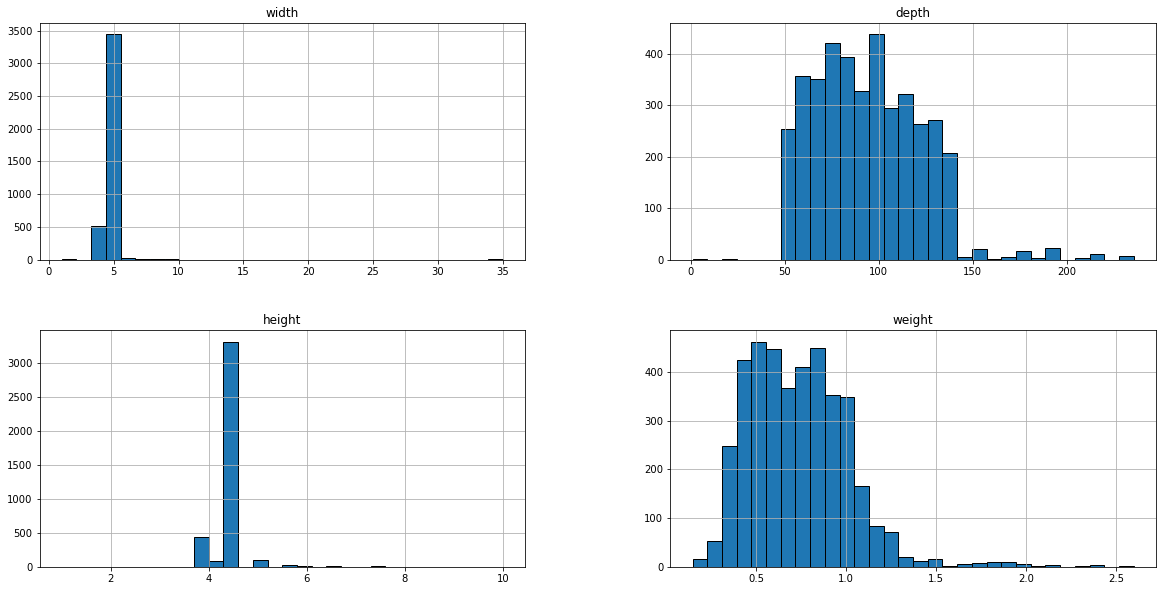

In [6]:
# visualizing overall distribution of features
df_hist = df.drop('reference', axis=1)
df_hist.hist(figsize=(20,10), bins=30, edgecolor='black')
plt.show()

The width and height data looks inbalanced and roller blinds have repeatable dimensions. Depth and weight data have more normally distributed results. We can spot some anomalies on these plots (values that are significantly distant from the means). We can also conclude from these histograms that there might be some correlation and that packaging weight depends mostly on its depth. This makes sense because roller blinds have small cross-sections and depths are much larger compared to them.

### 1. Inter Quartile Range (IQR)

This is the most common method for delecting outliers based on statistical dispersion. It is defined as the spread difference between the 75th and 25th percentiles of the data. It calculates values as the difference between the upper and lower quartiles, *Q3* and *Q1*. Each quartile is a median: *Q1* as median of the *n* smallest values, and *Q3* as median of the *n* largest values. IQR method also implements some non-negative constant *k*. For detecting outliers within continuous variables, John Tukey proposed for this test *k* = 1.5.

In [7]:
# defining quartiles without 'reference' column
Q1 = df.drop('reference', axis=1).quantile(.25)
Q3 = df.drop('reference', axis=1).quantile(.75)
IQR = Q3 - Q1
k = 1.5

# counting outliers for each column - frequency of 'True' value
((df < (Q1 - k * IQR)) | (df > (Q3 + k * IQR))).drop('reference', axis=1).sum()

depth      48
height    690
weight     65
width     693
dtype: int64

One of the most readable plot for outliers and IQR results is the box plot. There are four relevant fences:
* lower inner fence: *Q1* - 1.5 * IQR;
* upper inner fence: *Q3* + 1.5 * IQR;
* lower outer fence: *Q1* - 3 * IQR;
* upper outer fence: *Q3* + 3 * IQR.

The line in the middle of the box is the median (or second quartile *Q2*). Points that fall beyond the outer fences are called outliers.

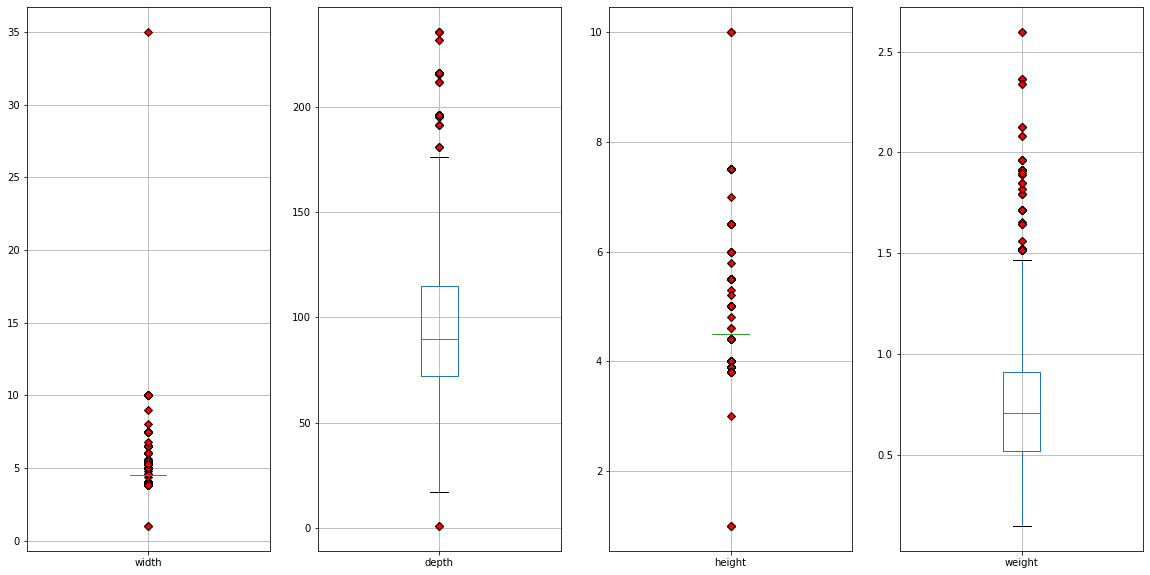

In [8]:
# visualizing IQR results with box plots
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))

m = 1
for i in range(4):
    red_diamond = dict(markerfacecolor='r', marker='D', markersize=6)
    df.boxplot(column=df.columns[m],  ax=ax[i], flierprops=red_diamond, vert=True)
    m +=1
    
plt.show()

In [9]:
# creating dataframe
def iqr_dataframe(x):
    
    if type(x) is not pd.core.frame.DataFrame:
        raise ValueError('Passed argument must be a dataframe')
    
    Q1 = x.drop('reference', axis=1).quantile(.25)
    Q3 = x.drop('reference', axis=1).quantile(.75)
    IQR = Q3 - Q1
    iqr = ((x < (Q1 - 1.5 * IQR)) | (x > (Q3 + 1.5 * IQR))).drop('reference', axis=1)
    
    # adding new columns
    iqr['reference'] = x['reference']
    iqr['outlier'] = ((iqr['width'] == True) | (iqr['depth'] == True) | (iqr['height'] == True) | (iqr['weight'] == True))
    return iqr

iqr = iqr_dataframe(df)
iqr.head()

,depth,height,weight,width,reference,outlier
0,False,True,False,True,45346315,True
1,False,False,False,False,45346322,False
2,False,False,False,False,45346336,False
3,False,False,False,False,45346343,False
4,False,False,False,False,45346350,False


In [10]:
# counting inliers and outliers
iqr['outlier'].value_counts()

False    3278
True      720
Name: outlier, dtype: int64

In [11]:
# returning data points (references) which are outliers
iqr.loc[iqr['outlier'] != False]

,depth,height,weight,width,reference,outlier
0,False,True,False,True,45346315,True
50,False,True,False,True,45346462,True
51,True,True,True,True,45346483,True
52,True,True,True,True,45346805,True
53,True,True,True,True,45347211,True
...,...,...,...,...,...,...
3993,False,True,False,True,83246030,True
3994,False,True,False,True,83246031,True
3995,False,True,False,True,83246032,True
3996,False,True,True,True,83246033,True


<function matplotlib.pyplot.show(close=None, block=None)>

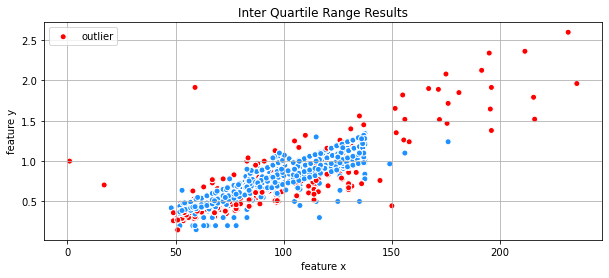

In [12]:
# visualizing IQR results
plt.figure(figsize=(10, 4))
colors = {True: 'red', False: 'dodgerblue'}

plt.scatter(x=df['depth'], y=df['weight'], c=iqr['outlier'].map(colors), marker='o', edgecolors='white')
plt.title('Inter Quartile Range Results')
plt.grid(True)
plt.legend(labels=['outlier'])
plt.xlabel('feature x')
plt.ylabel('feature y')
plt.show

We performed the IQR algorithm in order to detect anomalies in our features. Any incorrect dimension beyond quartiles classifies data point as an outlier.

### 2. Isolation Forest

It is a machine-learning algorithm build based on binary random forests proposed by Fei Tony Liu, Kai Ming Ting and Zhi-Hua Zhou in 2008. Since there are no pre-defined labels or true values here, it is an unsupervised model. It would be a complex operation for checking each row in the data for detecting such records which can be considered as anomalies. Isolation forest not only detects outliers faster but also requires less memory compared to other algorithms. It works great with large datasets. Isolation forest seperates outliers in the data points instead of profiling normal data points. As anomalies data points mostly have a lot shorter tree paths than the normal data points, trees in the isolation forest does not need to have a large depth, so a smaller max-depth value can be used resulting in low memory requirement.

The major limitation of this method is the necessity of passing the contamination value - the ratio between anomalies and all observations. This parameter is an estimation of anomaly population in our dataset (which we obviously want to determine). We can make use of previous IQR results and implement them or set the argument as *auto*.

Since the isolation forest is an unsupervised estimator, we will use the <code>fit_predict()</code> method. It is more relevant to unsupervised learning. The estimator returns -1 as inlier and 1 as anomaly. We will use this class from the <code>scikit-sklearn</code> API to develop our model.

#### First Method - Setting Contamination as Auto

Assuming we do not have any clue of anomaly proportion, we will set <code>contamination</code> as *auto* and see how many outliers we will get. <code>n_estimators</code> is the number of decision trees in the forest. According to Tony Liu, 100 by default should be sufficient in most cases.

In [13]:
from sklearn.ensemble import IsolationForest
iforest_1 = IsolationForest(contamination='auto', max_samples='auto', n_estimators=100)

# new dataframe (without 'reference' column)
iso_1 = df.copy().drop('reference', axis=1)

# fit model
iforest_1.fit_predict(iso_1)
# display parameters
iforest_1.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [14]:
# predicting values
iso_1['outlier'] = iforest_1.predict(iso_1)
# replace/map values in column
iso_1['outlier'] = iso_1['outlier'].map({1: False, -1: True})

# adding scores rates of the trained model
iso_1['score'] = iforest_1.decision_function(iso_1.drop('outlier', axis=1))

iso_1['reference'] = df['reference']
iso_1.head()

,width,depth,height,weight,outlier,score,reference
0,4.6,59.5,4.6,0.330,False,0.019253,45346315
1,4.5,60.5,4.5,0.370,False,0.086326,45346322
2,4.5,65.5,4.5,0.406,False,0.105824,45346336
3,4.5,69.5,4.5,0.424,False,0.107138,45346343
4,4.5,74.5,4.5,0.446,False,0.108866,45346350


In [15]:
# counting inliers and outliers
iso_1['outlier'].value_counts()

False    3458
True      540
Name: outlier, dtype: int64

#### Second Method - Setting Float Value for Contamination

This time, we will estimate <code>contamination</code> value based on previous IQR test results.

In [16]:
# find proportion of outliers in the dataset and round to two decimals
def contamination():
    a = iqr.loc[iqr['outlier'] != False].shape[0]
    b = df.shape[0]
    return round(a / b, 2)

contamination = contamination()
contamination

0.18

In [17]:
iforest_2 = IsolationForest(contamination=contamination, max_samples='auto', n_estimators=100)

# new dataframe (without 'reference' column)
iso_2 = iso_1.copy().drop(['outlier', 'score', 'reference'], axis=1)

# fit model
iforest_2.fit_predict(iso_2)
# display parameters
iforest_2.get_params()

{'bootstrap': False,
 'contamination': 0.18,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [18]:
# predicting values
iso_2['outlier'] = iforest_2.predict(iso_2)
# replace/map values in column
iso_2['outlier'] = iso_2['outlier'].map({1: False, -1: True})

# adding scores rates of the trained model
iso_2['score'] = iforest_2.decision_function(iso_2.drop('outlier', axis=1))

iso_2['reference'] = df['reference']
iso_2.head()

,width,depth,height,weight,outlier,score,reference
0,4.6,59.5,4.6,0.330,False,0.005358,45346315
1,4.5,60.5,4.5,0.370,False,0.074995,45346322
2,4.5,65.5,4.5,0.406,False,0.084583,45346336
3,4.5,69.5,4.5,0.424,False,0.086448,45346343
4,4.5,74.5,4.5,0.446,False,0.083949,45346350


In [19]:
# counting inliers and outliers
iso_2['outlier'].value_counts()

False    3278
True      720
Name: outlier, dtype: int64

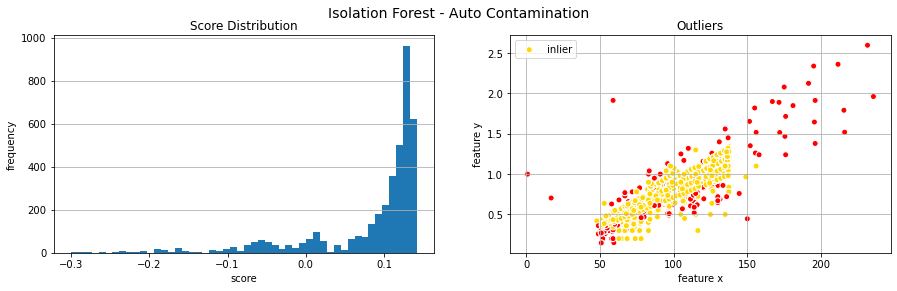

Numer of Outliers: 540
Accuracy: 0.08304670388564597


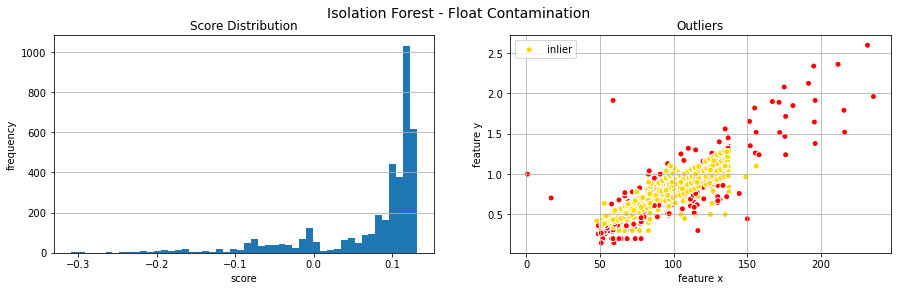

Numer of Outliers: 720
Accuracy: 0.07180539477525583


In [20]:
# visualizing isolation forest results
import matplotlib.colors as clrs
cmap = clrs.ListedColormap(['gold', 'red'])

# first method plots
fig = plt.figure(figsize=(15, 4))
fig.suptitle('Isolation Forest - Auto Contamination', size=14)
plt.tight_layout(pad=3)

# subplot_1
plt.subplot(1, 2, 1)
plt.hist(x=iso_1['score'], bins=50)
plt.title('Score Distribution')
plt.xlabel('score')
plt.ylabel('frequency')
plt.grid(axis='y')

# subplot_2
plt.subplot(1, 2, 2)
plt.scatter(x=df['depth'], y=df['weight'], c=iso_1['outlier'], marker='o', edgecolors='white', cmap=cmap)
plt.title('Outliers')
plt.grid(True)
plt.legend(labels=['inlier'])
plt.xlabel('feature x')
plt.ylabel('feature y')
plt.show()

print('Numer of Outliers:', (iso_1['outlier'] == True).sum())
print('Accuracy:', (iso_1['score']).mean())

# second method plots
fig = plt.figure(figsize=(15, 4))
fig.suptitle('Isolation Forest - Float Contamination', size=14)
plt.tight_layout(pad=3)

# subplot_1
plt.subplot(1, 2, 1)
plt.hist(x=iso_2['score'], bins=50)
plt.title('Score Distribution')
plt.xlabel('score')
plt.ylabel('frequency')
plt.grid(axis='y')

# subplot_2
plt.subplot(1, 2, 2)
plt.scatter(x=df['depth'], y=df['weight'], c=iso_2['outlier'], marker='o', edgecolors='white', cmap=cmap)
plt.title('Outliers')
plt.grid(True)
plt.legend(labels=['inlier'])
plt.xlabel('feature x')
plt.ylabel('feature y')
plt.show()

print('Numer of Outliers:', (iso_2['outlier'] == True).sum())
print('Accuracy:', (iso_2['score']).mean())

In [21]:
# comparing 'outlier' columns
(iso_1['outlier'] == iso_2['outlier']).value_counts()

True     3818
False     180
Name: outlier, dtype: int64

We trained two models with different values for <code>contamination</code> parameter to detect anomalies. Both returned different numbers of outliers. Unfortunately, we cannot evaluate these models. To validate their performance with basic metrics we need to compare the real and known anomalies, with the computed values. This approach is usually implemented in machine-learning when we split data into training and test samples. We prepaired a column of anomaly scores of the input samples. The lower the value, the more abnormal the observation is. Negative scores represent outliers, and positive scores represent inliers. We can set accuracy as mean value of all scores. The closer the value is to zero and further from one, the better.

Isolation forest model strongly depends on <code>contamination</code> argument which is not always easy to estimate. As seen above, each value will cause the model to learn differently. It is a hyperparameter which means that the user uses it to control the learning process. It is still a good practice to avoid setting it as *auto*. We can except the second model to be more accurate. It returned similar number of outliers as IQR technique.

### 3. Minimum Covariance Determinant (Elliptic Envelope or Robust Covariance)

This method for detecting outliers assumes the data is Gaussian distributed and that anomalies in a data leads increase in covariance, making the range of data larger. Based on computed minimum covariance determinants (MCD) the algorithm simply fits an ellipse around the data points to measure if the data is an outlier.

The estimator computes the mean, covariance and Mahalonobis distances for all points. It finds the covariance matrix with the smallest determinant that still covers a large portion of the data. Unlike classical tolerance, the elliptic envelope is a highly robust estimator of multivariate location and scatter. Just like isolation forest it classifies any observation within the figure as an inlier (labeled as 1) and any observation outside the ellipse as an anomaly (labeled as -1).

The minimum covariance determinant also uses <code>contamination</code> argument. To train this model we will implement the same value as previously.

In [22]:
from sklearn.covariance import EllipticEnvelope
ellipenv = EllipticEnvelope(contamination=contamination)

# new dataframe (without 'reference' column)
mcd = df.copy().drop('reference', axis=1)

# fit model
ellipenv.fit_predict(mcd)
# display parameters
ellipenv.get_params()

{'assume_centered': False,
 'contamination': 0.18,
 'random_state': None,
 'store_precision': True,
 'support_fraction': None}

In [23]:
# predicting values
mcd['outlier'] = ellipenv.predict(mcd)
# replace/map values in column
mcd['outlier'] = mcd['outlier'].map({1: False, -1: True})

# adding Mahalanobis distances relevance
mcd['distance'] = ellipenv.mahalanobis(mcd.drop('outlier', axis=1))

mcd['reference'] = df['reference']
mcd.head()

,width,depth,height,weight,outlier,distance,reference
0,4.6,59.5,4.6,0.330,False,5.815616,45346315
1,4.5,60.5,4.5,0.370,False,3.264178,45346322
2,4.5,65.5,4.5,0.406,False,2.938752,45346336
3,4.5,69.5,4.5,0.424,False,3.164711,45346343
4,4.5,74.5,4.5,0.446,False,3.655090,45346350


In [24]:
# counting inliers and outliers
mcd['outlier'].value_counts()

False    3281
True      717
Name: outlier, dtype: int64

In [25]:
# setting printing options
np.set_printoptions(precision=8, suppress=True)

# displaying robust covariance matrix - should be 4 x 4
ellipenv.correct_covariance(mcd.drop(['reference', 'distance', 'outlier'], axis=1))

array([[  0.00028439,  -0.00106096,   0.00028439,  -0.00000105],
       [ -0.00106096, 212.27911158,  -0.00106096,   1.71867772],
       [  0.00028439,  -0.00106096,   0.00028439,  -0.00000105],
       [ -0.00000105,   1.71867772,  -0.00000105,   0.0159251 ]])

In [26]:
# returning data points (references) which are outliers
mcd.loc[mcd['outlier'] != False]

,width,depth,height,weight,outlier,distance,reference
46,4.5,137.5,4.5,0.838,True,15.108664,45348114
49,4.5,137.5,4.5,0.838,True,15.108664,45348303
50,5.0,155.5,5.0,1.262,True,14.481238,45346462
51,5.0,195.5,5.0,1.646,True,24.943108,45346483
52,5.0,215.5,5.0,1.792,True,31.909925,45346805
...,...,...,...,...,...,...,...
3993,7.5,107.0,7.5,1.170,True,301.251172,83246030
3994,7.5,137.0,7.5,1.450,True,299.748885,83246031
3995,7.5,137.0,7.5,1.450,True,299.748885,83246032
3996,7.5,167.0,7.5,1.900,True,315.348130,83246033


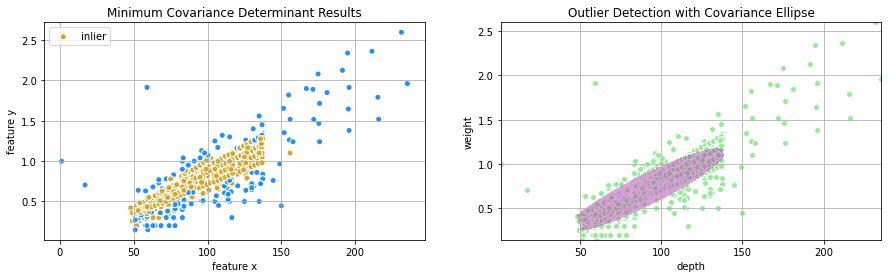

Covariance Matrix:
[[273.845111     2.5939028 ]
 [  2.5939028    0.02804376]]
Determinant of Covariance: 0.589564448927109
Numer of Outliers: 720


In [27]:
# visualizing elliptic envelope results
plt.figure(figsize=(15, 4))
colors = {True: 'dodgerblue', False: 'goldenrod'}

# subplot_1
plt.subplot(1, 2, 1)
plt.scatter(x=df['depth'], y=df['weight'], c=mcd['outlier'].map(colors), marker='o', edgecolors='white')
plt.title('Minimum Covariance Determinant Results')
plt.grid(True)
plt.legend(labels=['inlier'])
plt.xlabel('feature x')
plt.ylabel('feature y')
plt.show

# subplot_2
# training new classifier and plotting results
plt.subplot(1, 2, 2)
clf = EllipticEnvelope(contamination=contamination)

# new two-featured data
X1 = df[['depth', 'weight']]

# ellipse
xx1, yy1 = np.meshgrid(df['depth'], df['weight'])
clf.fit_predict(X1)
Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
Z1 = Z1.reshape(xx1.shape)
plt.contour(xx1, yy1, Z1, levels=[0], linewidths=0.03, alpha=0.1, colors=['plum'])
# scatter plot
plt.scatter(x=df['depth'], y=df['weight'], color='lightgreen', marker='o', edgecolors='white')
plt.title('Outlier Detection with Covariance Ellipse')
plt.grid(True)
plt.xlabel('depth')
plt.ylabel('weight')
plt.show()

np.set_printoptions(precision=8, suppress=True)
print('Covariance Matrix:')
print(clf.correct_covariance(X1))
print('Determinant of Covariance:', np.linalg.det(clf.correct_covariance(X1)))
print('Numer of Outliers:', (clf.predict(X1) == -1).sum())

We have demonstrated the robust elliptic envelope method and obtained very similar outlier distribution as in previous techniques (left figure).

This time we setted new data and implemented MCD used the same <code>contamination</code> argument as previous. Our goal is to plot elliptic boundary of our machine-learning model to see how this estimator performed. With practice we can then see the data and understand how the model classifies anomalies. It is interesting to see in depth how MCD understands the task geometrically. Overall, the covariance matrix is useful for geometric interpretation and defines the shape of the scattered data. Using the values in covariance matrix we can obtain more details about the figure (axes and angle of inclination). Data distributed inside the ellipse are correct observations. Looking at both scatter plots, indeed the error ellipse and yellow points do overlap. Also, the tilt angle clearly displays a positive correlation between depth and weight as observed earlier.

### 4. Z-score Treatment

Another statistical technique that is suited for features that are approximately normally distributed. Z-scores are the number of standard deviations above and below the mean value of what is being observed or measured. The mathematical formula is simple and for this process is the following:

$$Z = \frac{X_i - \mu }{\delta },$$

where $X_i$ is the observation, $μ$ is the mean of all measurements, and $δ$ the standard deviation. While calculating the Z-score we rescale and center the data and look for data points which are significantly far from zero. These data points which are way too far from zero will be treated as the anomalies. In most of the cases a threshold of 3 or -3 is implemented. For example, if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be classified as outlier. The statistical test is easy to implement and interpreting the final results is also not tricky.

#### First Method - Manual Boundary Definition

We will set upper and lower boundaries according to the Z-score test theory, and filter out our anomalies.

In [28]:
# finding the boundary values for each column (without 'reference' column)
upper_bound = df.drop('reference', axis=1).mean() + 3 * df.drop('reference', axis=1).std()
lower_bound = df.drop('reference', axis=1).mean() - 3 * df.drop('reference', axis=1).std()

# summing the outliers for each column
((df.drop('reference', axis=1) > upper_bound) | (df.drop('reference', axis=1) < lower_bound)).sum()

width     35
depth     48
height    35
weight    48
dtype: int64

In [29]:
# creating dataframe
def Z1_dataframe(x):
    
    if type(x) is not pd.core.frame.DataFrame:
        raise ValueError('Passed argument must be a dataframe')
        
    upper = x.drop('reference', axis=1).mean() + 3 * x.drop('reference', axis=1).std()
    lower = x.drop('reference', axis=1).mean() - 3 * x.drop('reference', axis=1).std()
    Z1 = ((x.drop('reference', axis=1) > upper) | (x.drop('reference', axis=1) < lower))
    
    # adding new columns
    Z1['reference'] = x['reference']
    Z1['outlier'] = ((Z1['width'] == True) | (Z1['depth'] == True) | (Z1['height'] == True) | (Z1['weight'] == True))
    return Z1

Z1 = Z1_dataframe(df)
Z1.head()

,width,depth,height,weight,reference,outlier
0,False,False,False,False,45346315,False
1,False,False,False,False,45346322,False
2,False,False,False,False,45346336,False
3,False,False,False,False,45346343,False
4,False,False,False,False,45346350,False


In [30]:
# counting inliers and outliers
Z1['outlier'].value_counts()

False    3905
True       93
Name: outlier, dtype: int64

In [31]:
# return data points (references) which are outliers
Z1.loc[Z1['outlier'] != False]

,width,depth,height,weight,reference,outlier
51,False,True,False,True,45346483,True
52,False,True,False,True,45346805,True
53,False,True,False,True,45347211,True
55,False,True,False,True,45348163,True
56,False,True,False,True,45348170,True
...,...,...,...,...,...,...
3993,True,False,True,False,83246030,True
3994,True,False,True,False,83246031,True
3995,True,False,True,False,83246032,True
3996,True,False,True,True,83246033,True


#### Second Method - Using API Function

<code>Scipy</code> library offers a built-in function for calculating the Z-score. We will compute the Z-score of each value in the sample and detect anomalies.<br>
For the test we will only accept threshold equal 3.

In [32]:
from scipy import stats

# calculating Z-scores without 'reference' column and creating dataframe
def Z2_dataframe(x):
    
    if type(x) is not pd.core.frame.DataFrame:
        raise ValueError('Passed argument must be a dataframe')    
       
    Z2 = np.abs(stats.zscore(x.drop('reference', axis=1)))
    
    # adding new columns
    threshold = 3
    Z2['reference'] = x['reference']
    Z2['outlier'] = ((Z2['width'] > threshold) | (Z2['depth'] > threshold) \
                     | (Z2['height'] > threshold) | (Z2['weight'] > threshold))
    return Z2

Z2 = Z2_dataframe(df)
Z2.head()

,width,depth,height,weight,reference,outlier
0,0.200478,1.210425,0.406734,1.444685,45346315,False
1,0.046608,1.175506,0.136972,1.302027,45346322,False
2,0.046608,1.000911,0.136972,1.173634,45346336,False
3,0.046608,0.861235,0.136972,1.109438,45346343,False
4,0.046608,0.686640,0.136972,1.030976,45346350,False


In [33]:
# counting inliers and outliers
Z2['outlier'].value_counts()

False    3905
True       93
Name: outlier, dtype: int64

In [34]:
# return data points (references) which are outliers
Z2.loc[Z2['outlier'] != False]

,width,depth,height,weight,reference,outlier
51,0.815960,3.538557,1.485780,3.248764,45346483,True
52,0.815960,4.236937,1.485780,3.769466,45346805,True
53,0.815960,4.935317,1.485780,4.375763,45347211,True
55,0.815960,3.538557,1.485780,3.248764,45348163,True
56,0.815960,4.236937,1.485780,3.769466,45348170,True
...,...,...,...,...,...,...
3993,4.662721,0.448227,8.229818,1.551134,83246030,True
3994,4.662721,1.495796,8.229818,2.549740,83246031,True
3995,4.662721,1.495796,8.229818,2.549740,83246032,True
3996,4.662721,2.543366,8.229818,4.154643,83246033,True


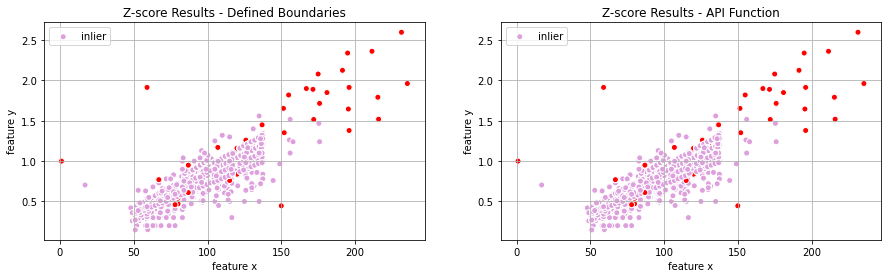

In [35]:
# visualizing Z-score results
plt.figure(figsize=(15, 4))
# space between charts
plt.tight_layout(pad=6)
colors = {True: 'red', False: 'plum'}

# subplot_1 - 1st method
plt.subplot(1, 2, 1)
plt.scatter(x=df['depth'], y=df['weight'], c=Z1['outlier'].map(colors), marker='o', edgecolors='white')
plt.title('Z-score Results - Defined Boundaries')
plt.grid(True)
plt.legend(labels=['inlier'])
plt.xlabel('feature x')
plt.ylabel('feature y')

# subplot_2 - 2nd method
plt.subplot(1, 2, 2)
plt.scatter(x=df['depth'], y=df['weight'], c=Z2['outlier'].map(colors), marker='o', edgecolors='white')
plt.title('Z-score Results - API Function')
plt.grid(True)
plt.legend(labels=['inlier'])
plt.xlabel('feature x')
plt.ylabel('feature y')
plt.show()

In [36]:
# comparing 'outlier' results
(Z1['outlier'] == Z2['outlier']).value_counts()

True    3998
Name: outlier, dtype: int64

We detected outliers in sample dataset using Z-score treatment. Both Z-score tests returned the exact same results.

Lets summarize all plots and results in tabular form for a clearer overview.

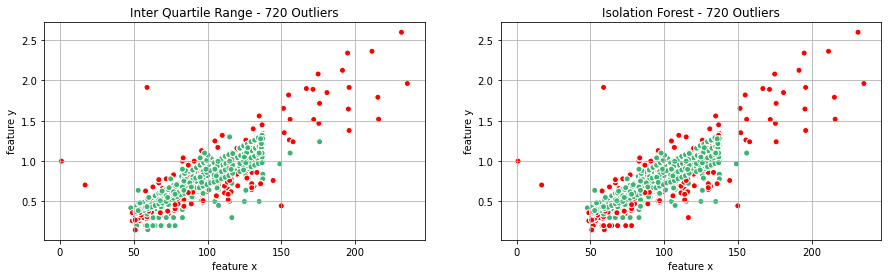

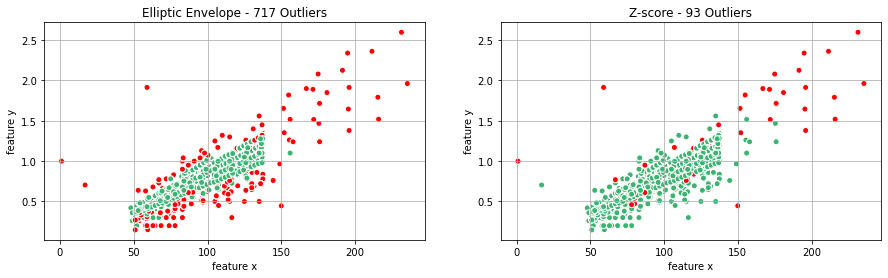

In [37]:
# summarize results
### 1st row
plt.figure(figsize=(15, 4))
colors = {True: 'red', False: 'mediumseagreen'}

# subplot_1
plt.subplot(1, 2, 1)
plt.scatter(x=df['depth'], y=df['weight'], c=iqr['outlier'].map(colors), marker='o', edgecolors='white')
plt.title('Inter Quartile Range - %.f Outliers' %(iqr['outlier'] == True).sum())
plt.grid(True)
plt.xlabel('feature x')
plt.ylabel('feature y')

# subplot_2
plt.subplot(1, 2, 2)
plt.scatter(x=df['depth'], y=df['weight'], c=iso_2['outlier'].map(colors), marker='o', edgecolors='white')
plt.title('Isolation Forest - %.f Outliers' %(iso_2['outlier'] == True).sum())
plt.grid(True)
plt.xlabel('feature x')
plt.ylabel('feature y')
plt.show()

### 2nd row
plt.figure(figsize=(15, 4))

# subplot_3
plt.subplot(1, 2, 1)
plt.scatter(x=df['depth'], y=df['weight'], c=mcd['outlier'].map(colors), marker='o', edgecolors='white')
plt.title('Elliptic Envelope - %.f Outliers' %(mcd['outlier'] == True).sum())
plt.grid(True)
plt.xlabel('feature x')
plt.ylabel('feature y')

# subplot_4
plt.subplot(1, 2, 2)
plt.scatter(x=df['depth'], y=df['weight'], c=Z2['outlier'].map(colors), marker='o', edgecolors='white')
plt.title('Z-score - %.f Outliers' %(Z2['outlier'] == True).sum())
plt.grid(True)
plt.xlabel('feature x')
plt.ylabel('feature y')
plt.show()

| **Estimator** | Interquartile<br>Range | Isolation<br>Forest | Elliptic<br>Envelope | Z-score |
|---------------|------------------------|---------------------|----------------------|---------|
| **Outliers**  | 720                    | 720                 | 717                  | 93      |

### 5. Conclusions

In this notebook we wanted to identify possible logistic data that outstand or do not fit in a dataset. We successfully reviewed different outlier detection models and illustrated its resistance to outliers on a real-life sammple. Each technique classifies anomalies differently and we recieved different results for each.

It is very hard to clearly state which algorithm is the best choice since we were not able to evaluate their performances. The Z-score treatment seems to be the least convincing of all these estimators. The distribution and number of outliers is completely dissimilar. Not all columns followed the Gaussian distribution (width and height), which made this approach not accurate. The input data was not varied. Perhaps using a different measure for a non-normally distributed dataset would be a better choice (a median instead of mean). In practice, the other three techniques performed well and were suitable for logistic dimensions. Their good efficiency was mostly caused by passing the accurate value of contamination which plays a major role.

Identifying and removing outliers is challenging with simple statistical methods for most machine-learning datasets given the large number of input variables. Most algorithms for detecting anomalies are based on the assumption that input measurements in the dataset are normally distributed. There is no single best technique for detecting outliers and we need to develop a few models for better insights. Finding anomalies should be a mandatory stage in data governance/engineering, which can help avoid further technical frustrations. This will allow users avoid working and cleaning messy master data, and to accelerate further tasks - in our specifical case warehouse management or demand planning.

There are different actions to take when it comes to handling outliers:
* removing (dropping) - not the best option, we can lose losts of information and remove actual, extreme values;
* marking - the safest option, we can check if the anomalies have an effect or distort final measures;
* rescaling or adjusting - for example, using a log function so that the values don't effect.

If at all possible, we should take a look at data points we detect as outliers and try to understand them. Sometimes we might need to verify these rows manualy. For example, a twenty passenger car is actually a misclassified minibus. Some extreme values might be true or indicate broken measuring devices. We also need to keep in mind that some logistic measurments still might have been reversed, which can cause the estimators to find errors.

The incorrect references will be forwarded to suppliers for further re-verification and updating the database in accordance with accepted business rules.